# **Agoda Mapping Challenge**
The following code cell is used only when working within Google's Colab workspace:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install recordlinkage

     |████████████████████████████████| 952kB 2.8MB/s 
     |████████████████████████████████| 143kB 44.9MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.7.2-cp36-cp36m-linux_x86_64.whl size=72984 sha256=8dc57fba282b81c0d5b4729f62db7759ba2b67b8b0bf99663def596d05a7ad3a
  Stored in directory: /root/.cache/pip/wheels/e8/fe/99/d8fa8f2ef7b82a625b0b77a84d319b0b50693659823c4effb4
Successfully built jellyfish


In [0]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import recordlinkage
from recordlinkage.preprocessing import clean
from recordlinkage.base import BaseClassifier
from recordlinkage.adapters import SKLearnAdapter

import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import ensemble, metrics, model_selection

In [0]:
filepath = '/content/drive/My Drive/Work/Job Assignments/Agoda/mappinghotelsdataset.xlsx'
df_p1 = pd.read_excel(filepath, sheet_name='Partner1')
df_p2 = pd.read_excel(filepath, sheet_name='Partner2')
df_examples = pd.read_excel(filepath, sheet_name='examples')

# Basic EDA and a pair-matching baseline

In [5]:
display(df_p1.head(6))

,p1.key,p1.hotel_name,p1.city_name,p1.country_code,p1.hotel_address,p1.star_rating,p1.postal_code
0,5E876BFEA81A39E42E3019FE17303D52,Elite Grande Hotel,Manama,BH,"Bldg 3378, Road 2845, Area 428",4.0,5458
1,4F315989358CC0F3F7869F569887743D,Quality Inn West Chester,West Chester (OH),US,8567 Cincinnati Dayton Road,3.0,45069
2,A4EEBCBB9932DADE591248DFFFBDC068,MAP5 Village Resort,Goa,IN,Vithaldas Wadoo,3.0,403512
3,2833BE9FD49A063A36D3DE1E5E28ABC4,Hampton Inn & Suites San Jose Hotel,San Jose (CA),US,55 Old Tully Road,3.0,95111
4,F7C20B50AE5C6C807BAABB65B8926F07,Favehotel Daeng Tompo,Makassar,ID,"Daeng Tompo Street number 28, Losari",3.0,NaN
5,C517E32BB18C1E2ED859947B25629103,Art Cottage Hotel,Ipoh,MY,"15 & 17,Jalan Medan Ipoh 1B/1",1.0,31400


**Assumptions:**


*   Since "Matches can only be made within
the same country (hotels with different country codes cannot be
matched with each other)", we'll assume country codes are noiseless. Otherwise, the following methods should be revisited. These will be used as our blocking, restricting comparisons only between them.
*   The rest of the columns have noise



In [6]:
print('number of sample points:', df_p1.shape[0])
print('number of sample points [in Examples]:', df_examples.shape[0])

# maximal length of entries per country:
print('maximal occurnces per country:',
      df_p1['p1.country_code'].value_counts().idxmax(), 'with',
      df_p1['p1.country_code'].value_counts().max(), 'occurrences')

print('number of occurences per country are equal (between',
      'Partner 1 and Partner 2):',
      df_p1['p1.country_code'].value_counts().equals(
          df_p2['p2.country_code'].value_counts()))

print('number of occurences per country are equal [in Examples]:',
      df_examples['p1.country_code'].value_counts().equals(
          df_examples['p2.country_code'].value_counts()))

number of sample points: 10000
number of sample points [in Examples]: 499
maximal occurnces per country: US with 962 occurrences
number of occurences per country are equal (between Partner 1 and Partner 2): False
number of occurences per country are equal [in Examples]: True


Let's examine missing data:

In [7]:
print('\nmissing data:')
display(df_p1.isna().sum())
display(df_p2.isna().sum())

print('\nmissing data in examples:')
display(df_examples.isna().sum())

display(df_p1.loc[df_p1['p1.country_code'].isna(), :].sort_values('p1.hotel_name'))
display(df_p2.loc[df_p2['p2.country_code'].isna(), :].sort_values('p2.hotel_name'))


missing data:


p1.key                 0
p1.hotel_name          0
p1.city_name           0
p1.country_code        5
p1.hotel_address       1
p1.star_rating         0
p1.postal_code      1750
dtype: int64

p2.key                0
p2.hotel_name         0
p2.city_name          0
p2.country_code       5
p2.hotel_address      1
p2.star_rating        0
p2.postal_code      664
dtype: int64


missing data in examples:


p1.key               0
p1.hotel_name        0
p1.city_name         0
p1.country_code      0
p1.hotel_address     0
p1.star_rating       0
p1.postal_code      99
p2.key               0
p2.hotel_name        0
p2.city_name         0
p2.country_code      0
p2.hotel_address     0
p2.star_rating       0
p2.postal_code      39
dtype: int64

,p1.key,p1.hotel_name,p1.city_name,p1.country_code,p1.hotel_address,p1.star_rating,p1.postal_code
9776,CBE71D01B60AF5E074935BCE2F434AF4,Bagatelle Kalahari Game Ranch Resort,Mariental,NaN,"Farm Bagatelle, D1268",3.0,9000
5735,C8A0A5B634A67365D57AB0983E601C62,Hotel Uhland,Windhoek,NaN,147 Uhland Street,1.0,9000
4784,0AC418BC2D45A6B8518096F1F00AF00F,Kunene River Lodge,Kunene,NaN,Banks of Kunene River 64km from Ruacana,3.0,9000
9896,F5782D38E38BE92661FC2A38A65335F1,Ndhovu Safari Lodge,Divundu,NaN,"Okavango River, Entrance to Mahangu National Park",3.0,9000
6048,4B36DF6237887FEE1B7A51FFF8F5F79F,Protea Hotel Zambezi River,Katima Mullo,NaN,"Ngoma Road, Katima Mulilo",3.0,NaN


,p2.key,p2.hotel_name,p2.city_name,p2.country_code,p2.hotel_address,p2.star_rating,p2.postal_code
1303,5256D45F46338BFFA68B84A7BEC99146,Bagatelle Kalahari Game Ranch,Hardap,NaN,Bagatelle Kalahari Game Ranch D1268,0.0,9000
5699,05E782BCA41AB39ED4F6602C9E54BAA8,Hotel Uhland,Windhoek,NaN,"147 Dr. Kenneth David Kaunda Street, former Uh...",0.0,9000
7776,437A055FE6E759CCA7269E9F3AFAAA1B,Kunene River Lodge,Ehomba,NaN,"D3701, Ruacana",0.0,9000
3134,9590C8BC8A30858FE272F3A08AD04173,Ndhovu Safari Lodge,Mahango,NaN,C 48 Divundu,0.0,NaN
9672,AEA31679E9873B89508E6A95DF23BBD8,Protea Hotel by Marriott Zambezi River Lodge,Katima Mulilo,NaN,Ngoma Road,3.0,9000


We see some hotels have no country code. A bit problematic, but it's easy to see they are linked. We'll process them as an uknown country.


In [0]:
df_p1.loc[df_p1['p1.country_code'].isna(), 'p1.country_code'] = 'UNK'
df_p2.loc[df_p2['p2.country_code'].isna(), 'p2.country_code'] = 'UNK'

Let's check the cities and star rating of the example, and how noisy they are:

Cities identical: 56.31%
Cities p1 and p2 differences (sample):
 ['Mae Suai / Wiang Pa Pao (Chiang Rai)' 'Calangute' '(NY)' 'Onjuku'
 'Shiretoko' 'Golden Triangle' 'Minamiizu' 'Lamai Beach' 'Taichung' '(TX)'
 'Tonsai Beach' 'Shizuoka' 'Whitsunday Islands' 'La' 'Sunshine Coast'
 'George Town' 'Yamanouchi' 'Thiruvananthapuram' '(MT)' '(NE)' 'City'
 'Haiphong' 'Island' 'Seminyak']

Histogram of Star Rating Absolute Differences:


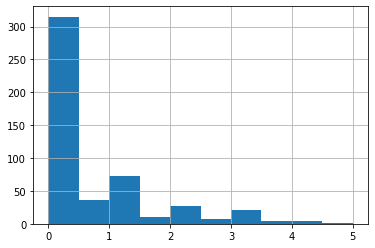

In [9]:
def str_compare(row):
  if len(row['p1.city_name']) > len(row['p2.city_name']):
    res = ''.join(row['p1.city_name'].split(row['p2.city_name'])).strip()
  elif len(row['p1.city_name']) < len(row['p2.city_name']):
    res = ''.join(row['p2.city_name'].split(row['p1.city_name'])).strip()
  else:
    res = None

  return res

cities = df_examples.apply(str_compare, axis=1)
print('Cities identical: {:.2%}'.format(cities.isna().sum()/len(cities)))
print('Cities p1 and p2 differences (sample):\n', cities.unique()[1:25])

print('\nHistogram of Star Rating Absolute Differences:')
(df_examples['p1.star_rating'] - df_examples['p2.star_rating']).abs().hist();

Some cities have an added "(country_code)" between p1 and p2, and some cities have a completely different name.
Star ratings are also noisy, as seen in the historgram.
Let's look at the postal codes:

In [10]:
print('P1 P2 data:')
print('Percentage of postal codes that are integers: p1-{:.1%}, p2-{:.1%}'.
        format(df_p1['p1.postal_code'].apply(
            lambda x: type(x) in [int, float]).sum() / len(df_p1),
            df_p2['p2.postal_code'].apply(
            lambda x: type(x) in [int, float]).sum() / len(df_p2)))
print('Percentage of postal codes that are strings: p1-{:.1%}, p2-{:.1%}'.
        format(df_p1['p1.postal_code'].apply(
            lambda x: type(x) == str).sum() / len(df_p1),
            df_p2['p2.postal_code'].apply(
            lambda x: type(x) == str).sum() / len(df_p2)))
print('Percentage of postal codes that are NA: p1-{:.1%}, p2-{:.1%}'.
        format(df_p1['p1.postal_code'].apply(
            pd.isna).sum() / len(df_p1),
            df_p2['p2.postal_code'].apply(
            pd.isna).sum() / len(df_p2)))

print('\nExample data:')
print('Percentage of postal codes that are integers: {:.1%}'.
        format(df_examples['p1.postal_code'].apply(
            lambda x: type(x) in [int, float]).sum() / len(df_examples)))
print('Percentage of postal codes that are strings: {:.1%}'.
        format(df_examples['p1.postal_code'].apply(
            lambda x: type(x) == str).sum() / len(df_examples)))
print('Percentage of postal codes that are NA: {:.1%}'.
        format(df_examples['p1.postal_code'].apply(
            pd.isna).sum() / len(df_examples)))
print('Sample of postal codes: {}'.
      format(df_examples['p1.postal_code'].unique()[:20]))

P1 P2 data:
Percentage of postal codes that are integers: p1-86.7%, p2-87.4%
Percentage of postal codes that are strings: p1-13.3%, p2-12.6%
Percentage of postal codes that are NA: p1-17.5%, p2-6.6%

Example data:
Percentage of postal codes that are integers: 87.8%
Percentage of postal codes that are strings: 12.2%
Percentage of postal codes that are NA: 19.8%
Sample of postal codes: [nan 57170 403516 13441 '299-5107' 90100 '140-201' 560017 '099-4403'
 '135-915' 57150 528000 '415-0303' 630117 946 84310 40744 77840 50200
 175131]


The postal code statistics for the example data and p1/p2 are very similar, apart from the number of NAs in p2. It might indicate Examples data were drawn from the same distribution as the rest of the data.


---


Some helper functions:

In [0]:
def eval_pairs(df_base, pairs):
  # calculate accuracy and coverage
  
  # df_base: pandas dataframe
  # pairs: pandas dataframe

  p1_col_ind = df_base.columns.get_loc('p1.key')
  p2_col_ind = df_base.columns.get_loc('p2.key')

  hits = 0
  mismatch = pd.DataFrame(columns=pairs.columns)

  for _, row in pairs.iterrows():
    base_p1_ind = np.argwhere(df_base['p1.key'].str.findall(row['p1.key']))[0]
    hits += df_base.iloc[base_p1_ind, p2_col_ind].values[0] == row['p2.key']

    if df_base.iloc[base_p1_ind, p2_col_ind].values[0] != row['p2.key']:
      mismatch = mismatch.append(row)

  acc = hits / pairs.shape[0]
  cov = hits / df_base.shape[0]
  return acc, cov, mismatch


def get_mismatches(df_base, pairs):
  # get mismatches into one dataframe

  # df_base: pandas dataframe
  # pairs: pandas dataframe

  # get relevant cols of p1 and p2
  p1_col = [col for col in df_base if col.startswith('p1')]
  p2_col = [col for col in df_base if col.startswith('p2')]

  df_mismatch = pd.DataFrame(columns=p1_col+p2_col)

  # join all pairs data into df_mismatch
  for _, row in pairs.iterrows():
    row_p1 = df_base.loc[df_base['p1.key'] == row['p1.key'], p1_col]
    row_p2 = df_base.loc[df_base['p2.key'] == row['p2.key'], p2_col]
    pair = pd.concat([row_p1.reset_index(drop=True), 
                      row_p2.reset_index(drop=True)], axis=1)

    df_mismatch = df_mismatch.append(pair, ignore_index=True)

  return df_mismatch


def get_match(df, pairs):
  # return multiindex list-indices of pairs
  links_arr = np.ndarray(shape=(2,0), dtype=int)
  for _, row in pairs.iterrows():
    if row['p1.key'] not in df['p1.key'].values:
      continue
    ind1 = df.loc[df['p1.key'] == row['p1.key'], :].index.values[0]
    ind2 = df.loc[df['p2.key'] == row['p2.key'], :].index.values[0]
    links_arr = np.hstack((links_arr, [[ind1], [ind2]]))
  match_list = pd.MultiIndex.from_arrays(links_arr)
  return match_list

# Preprocessing

  Let's use the clean() method of recordlinkage which turns all strings into lowercase and
  removes characters such as quotation marks and punctuation. Also,
  it automatically removes leading and trailing white-space and
  collapses consecutive white-space into a single space.

In [0]:
def preprocess(df):
  if 'p1.country_code' in df.columns:
    df.loc[df['p1.country_code'].isna(), 'p1.country_code'] = 'UNK'
  if 'p2.country_code' in df.columns:
    df.loc[df['p2.country_code'].isna(), 'p2.country_code'] = 'UNK'

  key_cols = [col for col in df if col.endswith('key')]
  country_code_cols = [col for col in df if col.endswith('country_code')]
  star_rating_cols = [col for col in df if col.endswith('star_rating')]

  for col in df.columns:
    if col in key_cols + country_code_cols + star_rating_cols: continue
    df.loc[:, col] = clean(df.loc[:, col])

  return df

# Feature engineering

In [13]:
def star_rate_compare(s1, s2):
  # if star_rate is at distance up to 0.5 then score is 1, else 0
  concat = pd.concat([s1, s2], axis=1, ignore_index=True)

  def star_comp(x):
    dist = max(0, 1 - np.abs(x[1] - x[0]))
    return float(dist)

  return concat.apply(star_comp, axis=1)


indexer = recordlinkage.Index()
indexer.block(left_on='p1.country_code', right_on='p2.country_code')

# set comparison parameters
c = recordlinkage.Compare()
c.string('p1.city_name', 'p2.city_name', label='city_name_lcs',
         method='lcs')
c.string('p1.city_name', 'p2.city_name', label='city_name_sw',
        method='smith_waterman')
c.string('p1.hotel_name', 'p2.hotel_name', label='hotel_name_lcs',
         method='lcs')
c.string('p1.hotel_name', 'p2.hotel_name', label='hotel_name_sw',
        method='smith_waterman')
c.string('p1.hotel_address', 'p2.hotel_address', label='hotel_address_sw',
        method='smith_waterman')
c.string('p1.hotel_address', 'p2.hotel_address', label='hotel_address_lcs',
        method='lcs')
c.string('p1.postal_code', 'p2.postal_code', label='postal_code_jarow',
        method='jarowinkler')
c.numeric('p1.star_rating', 'p2.star_rating', label='star_rating',
          method='linear', origin=0, offset=0.5, scale=0.5)

<Compare>

In [14]:
# prepare data
X = df_examples.copy()

# get true matches
matches = X[['p1.key', 'p2.key']].copy()

p1_cols = [col for col in X if col.startswith('p1')]
p2_cols = [col for col in X if col.startswith('p2')]

n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=0)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=5, random_state=0, shuffle=True)


# Build models


We'll use grid search for choosing model type.

In [0]:
class PipeClassifier(SKLearnAdapter, BaseClassifier):
  def __init__(self, *args, **kwargs):
    super().__init__()
    
    clf_pac = sklearn.linear_model.PassiveAggressiveClassifier()
    clf_svm = sklearn.svm.NuSVC(probability=True, gamma='auto')
    clf_rnf = ensemble.RandomForestClassifier()
    clf_lrc = sklearn.linear_model.LogisticRegression()

    param_grid = [
    {
    'clf': [clf_pac],
    'clf__C': [0.5, 1],
    },
    {
    'clf': [clf_lrc],
    },
    {
    'clf': [clf_svm],
    'clf__nu': [0.4, 0.5],
    'clf__kernel': ['linear', 'rbf'],
    },
    {
    'clf': [clf_rnf],
    'clf__n_estimators': [6, 7, 8],
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [4, 5],
    }
    ]

    pipe = Pipeline([
        ('clf', clf_lrc),
    ])

    clf = model_selection.GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        n_jobs=-1)

    # set the kernel
    self.kernel = clf

In [0]:
def prob_pairs_to_links(prob_pairs):
  df_prob = prob_pairs.reset_index()
  df_prob = df_prob.rename({'level_0': 'p1', 'level_1': 'p2', 0: 'prob'}, axis=1)
  df_prob = df_prob.sort_values('prob', ascending=False)

  # print('lowest prob:', df_prob.iloc[df_prob['p1'].nunique() ,2])

  pred_pairs = np.ndarray(shape=(2,0), dtype=int)  

  for _, row in df_prob.iterrows():
    p1_ind = int(row.values[0])
    p2_ind = int(row.values[1])
    if (p1_ind in pred_pairs[0, :]) or (p2_ind in pred_pairs[1, :]): continue
    pred_pairs = np.hstack((pred_pairs, [[p1_ind], [p2_ind]]))

  return pd.MultiIndex.from_arrays(pred_pairs)

In [20]:
acc, cov = [], []

# cross validate the models
for count, (train_index, test_index) in enumerate(kf.split(X), 1):
  print('cv split', count, 'out of', n_splits)

  # split train-test
  X_train = X.iloc[train_index, :].copy()
  X_test = X.iloc[test_index, :].copy()

  # shuffle p2 rows
  X_train = pd.concat([X_train[p1_cols],
                       X_train[p2_cols].sample(
                           frac=1, random_state=0).set_index(X_train.index)], 
                      axis=1)
  X_test = pd.concat([X_test[p1_cols],
                      X_test[p2_cols].sample(
                          frac=1, random_state=0).set_index(X_test.index)],
                     axis=1)

  # train
  # preprocess and indexer
  X_train = preprocess(X_train)
  candidate_links = indexer.index(X_train, X_train)
  
  # compute feature vectors
  features = c.compute(candidate_links, X_train)

  # get pair labels for features
  true_pairs = get_match(X_train, matches)
  true_pairs_ind = features.index & true_pairs

  clf = PipeClassifier()
  train_pred = clf.fit_predict(features, true_pairs_ind)
  
  # test
  X_test = preprocess(X_test)
  candidate_links = indexer.index(X_test, X_test)
  features = c.compute(candidate_links, X_test)

  # display(features.describe())

  true_pairs = get_match(X_test, matches)
  true_pairs_ind = features.index & true_pairs
  prob_pairs = clf.prob(features)

  pred_pairs = prob_pairs_to_links(prob_pairs)

  # evaluate
  # FP = true_pairs.difference(pred_pairs).size
  # TP = true_pairs.intersection(pred_pairs).size
  # print('Acc:', TP/pred_pairs.size)
  # print('Cov:', TP/true_pairs.size)
  
  acc.append(recordlinkage.precision(true_pairs, pred_pairs))
  cov.append(recordlinkage.recall(true_pairs, pred_pairs))

print('Test accuracy: mean-{:.2%}, std-{:.2%}'.format(np.mean(acc), 
                                                      np.std(acc)))
print('Test coverage: mean-{:.2%}, std-{:.2%}'.format(np.mean(cov),
                                                      np.std(cov)))

cv split 1 out of 5
cv split 2 out of 5
cv split 3 out of 5
cv split 4 out of 5
cv split 5 out of 5
Test accuracy: mean-100.00%, std-0.00%
Test coverage: mean-100.00%, std-0.00%


In [21]:
print(clf.kernel.best_estimator_)
print(clf.kernel.best_params_)

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}


# Untagged data

The blocks here are not indexed by country, due to long computational time.
Instead, manually broken down by a for-loop for each country code.
Also, iteratively picks up from the last country that was processed, that is for the case that the Colab connection breaks during the for-loop.
Organize p1 and p2 keys and save to file

In [22]:
import os.path

df_p1 = preprocess(df_p1)
df_p2 = preprocess(df_p2)

filepath = '/content/drive/My Drive/Work/Job Assignments/Agoda/ROI_MAISHAR/mappings.csv'

# get last country that was processed
if os.path.isfile(filepath):
  with open(filepath, 'r', encoding='utf-8') as outfile:
    pairs = pd.read_csv(outfile)
    last_key = pairs.iloc[-1, 0]

  last_country = df_p1.loc[df_p1['p1.key'] == last_key, 'p1.country_code'].values
else:
  last_country = ''

# process by country_code blocks
for country, df_p1_country in df_p1.groupby('p1.country_code'):
  print(country)
  if min(last_country, country) == country: continue

  # prepare data
  df_p2_country = df_p2.loc[df_p2['p2.country_code'] == country, :].set_index(df_p1_country.index)
  X_test = pd.concat([df_p1_country, df_p2_country], axis=1).reset_index(drop=True)

  # run prediction
  candidate_links = indexer.index(X_test, X_test)
  print(country, 'links:', candidate_links.shape[0])
  features = c.compute(candidate_links, X_test)
  prob_pairs = clf.prob(features)
  pred_pairs = prob_pairs_to_links(prob_pairs)

  # TODO: stay with multiindex instead of converting to ndarray
  links_arr = np.ndarray(shape=(0,2), dtype=int)  
  for link in pred_pairs:
    links_arr = np.vstack((links_arr, link))

  # join p1 and p2 keys
  pairs = pd.concat(
      [X_test.iloc[links_arr[:,0], X_test.columns.get_loc('p1.key')].reset_index(drop=True),
      X_test.iloc[links_arr[:,1], X_test.columns.get_loc('p2.key')].reset_index(drop=True)],
      axis=1, ignore_index=True)
  pairs.rename(columns={0: "P1.key", 1: "P2.key"}, inplace=True)

  with open(filepath, 'a+', encoding='utf-8') as outfile:
    pairs.to_csv(outfile, index=False, header=False)

print('done comp')

AE
AL
AR
AT
AU
AZ
BA
BD
BE
BG
BH
BN
BO
BR
BT
BW
CA
CH
CI
CK
CL
CN
CO
CR
CV
CY
CZ
DE
DK
DO
EE
EG
ES
ET
FI
FJ
FR
GB
GH
GR
GU
HK
HR
HU
ID
IE
IL
IN
IS
IT
JM
JO
JP
KE
KH
KR
KW
KZ
LA
LB
LK
LT
LU
LV
MA
MD
ME
MG
MK
MM
MN
MO
MP
MT
MU
MV
MX
MY
MZ
NC
NF
NG
NL
NO
NP
NZ
OM
PA
PE
PF
PG
PH
PK
PL
PR
PT
PW
QA
RE
RO
RS
RU
SA
SC
SE
SG
SI
SK
TH
TN
TO
TR
TW
TZ
UA
UG
UNK
US
UY
VN
VU
WS
XK
ZA
ZW
done comp
